# Построение модели кредитного скоринга
![фото печенья с предсказанием](https://sun9-61.userapi.com/impg/B5E8wbfD6eohiBNQbf3eCdqMc7xXM12scZZPGQ/HfatNRQrwj8.jpg?size=1280x437&quality=95&sign=b20bceb70818c55efcb7eb63fe9768fa&type=album)


### IMPORT LIBRARY

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, confusion_matrix, mean_squared_error, accuracy_score, precision_score, brier_score_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, f1_score, log_loss, average_precision_score


from statistics import mode
from sklearn import preprocessing
from pandas import Series
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', None)

In [2]:
# фиксируем random_seed для воспроизводимости
RANDOM_SEED = 42

In [3]:
import warnings
warnings.filterwarnings("ignore")

### FUNCTIONS

In [4]:

def IQR(df, column): 
    ''' Функция для подсчета межквартильного размаха,
    нижних и верхних границ выбросов данных'''
    
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    # границы выбросов
    min_limit = perc25 - 1.5*iqr
    max_limit = perc75 + 1.5*iqr
      
    print('Нижняя граница выбросов:', min_limit,'\n'
          'Верхняя граница выбросов:', max_limit)
    
    #считаем количество выбросов
    print('Количество выбросов:',
         df[df[column]<(perc25-1.5*iqr)][column].count() +
          df[df[column]>(perc75+1.5*iqr)][column].count())
    
def fill_mean(df, column):
    ''' Функция для замены выбросов на среднее значение'''
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

     # границы выбросов
    min_limit = perc25 - 1.5*iqr
    max_limit = perc75 + 1.5*iqr
    
    # замена выбросов на среднее
    df[column] = df[column].apply(lambda a: df[column].mean() if a < min_limit else a)
    df[column] = df[column].apply(lambda a: df[column].mean() if a > max_limit else a)
    
def log_func(df, column):  
    ''' Функция для логарифмирования данных'''
    df[column] = df[column].apply(lambda s: np.log(s+1))
    

def scores_function(y_test, y_pred, prob):
    ''' Функция подсчета метрик оценки модели
    и построения ROC-AUC кривой'''
    fpr, tpr, threshold = roc_curve(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    print ("accuracy_score:",round(accuracy_score(y_test,y_pred), 3))
    print ("precision_score:",round(precision_score(y_test,y_pred), 3))
    print ("recall_score:",round(recall_score(y_test,y_pred), 3))
    print ("f1_score:",round(f1_score(y_test,y_pred), 3)) 
    print ("log_loss:",round(log_loss(y_test,y_pred), 3))
    print ("roc_auc_score:",round(roc_auc, 3))
    print("average_precision_score:", round(average_precision_score(y_test,y_pred), 3))
    print("brier_score_loss:", round(brier_score_loss(y_test,y_pred), 3))
   
  
      
def confusion_matrix(lastmodel, X_test, y_test):
    ''' Функция графического отображения confusion matrix '''
    sns.set(rc={'figure.figsize':(5, 5)})
    
    class_names = ['NonDefault', 'Default']
    titles_options = [("Confusion matrix", None)]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(lastmodel, X_test, y_test, 
                                     display_labels=class_names, 
                                     cmap=plt.cm.Blues, 
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

### IMPORT DATASET

***FOR JUPYTER***

In [5]:
# тренировочный (train, используется для обучения модели)
train = pd.read_csv('train.csv')

# тестовый (test, используется для оценки точности модели)
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
print('Размер тренировочного датасета: ', train.shape)
display(train.head(), train.info())

Размер тренировочного датасета:  (73799, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


None

In [7]:
train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

**В тренировочной части датасета:**
* 19 - колонок
* 12 - числовых колонок
* 6 - смешанного типа
* 1 - булевый тип данных
* Пропуски имеются в одной колонке **education** в количестве 307
* При более внимательном рассмотрении заметно, что там имеются колонки с бинарным типом данных, категориальным и числовыми, а так же одна колонка с временным рядом - все это требует последующей обработки

    

In [8]:
print('Размер тестового датасета: ', test.shape)
display(test.head(), test.info())

Размер тестового датасета:  (36349, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


None

In [9]:
test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

**В тестовой части датасета:**
* 18 - колонок
* 11 - числовых колонок
* 6 - смешанного типа
* 1 - булевый тип данных
* Пропуски имеются в одной колонке **education** в количестве 171
* При более внимательном рассмотрении заметно, что там имеются колонки с бинарным типом данных, категориальным и числовыми, а так же одна колонка с временным рядом - все это требует последующей обработки
* Колонка default отсутствует

    

### **Посмотрим на значение колонок:**

* **client_id** - идентификатор клиента
* **education** - уровень образования
* **sex** -	пол заёмщика
* **age** - возраст заёмщика
* **car** - флаг наличия автомобиля
* **car_type** - флаг автомобиля-иномарки
* **decline_app_cnt** -	количество отказанных прошлых заявок
* **good_work** - флаг наличия «хорошей» работы
* **bki_request_cnt** - количество запросов в БКИ
* **home_address** - категоризатор домашнего адреса
* **work_address** -категоризатор рабочего адреса
* **income** - доход заёмщика
* **foreign_passport** - наличие загранпаспорта
* **sna** - связь заемщика с клиентами банка
* **first_time** - давность наличия информации о заемщике
* **score_bki** - скоринговый балл по данным из БКИ
* **region_rating** - рейтинг региона
* **app_date** - дата подачи заявки
* **default** - наличие дефолта у клиента по кредиту

### Соединим обе выборки для дальнейшего корректного анализа:

In [10]:
train['sample'] = 1 # помечаем train
test['sample'] = 0 # помечаем test
# в тестовой выборке этой колонки нет, т.к мы ее и предсказываем, создаем и заполняем нулями
test['default'] = 0

data = train.append(test, sort = False).reset_index(drop=True) 

In [11]:
display(data.head(), data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


None

In [12]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

***Выводы по предварительному осмотру данных:***
* В тренировочной выборке - 73799 клиентов
* В тестовой - 36349 клиентов
* Всего: представлены данные о 110148 клиентах
* Имеем 18 переменных (без учета созданных)
* 1 - временной ряд
* 5 - бинарных
* 6 - категориальных 
* 6 - числовых
* Пропуски лишь в переменной ***education***
* ***client_id*** - уникальный числовой идентификатор, который по сути не несет информации для предсказания дефолта

### Создадим списки колонок по категориям: 

In [13]:
# временной ряд
time_cols = ['app_date']

# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
            'score_bki', 'region_rating', 'first_time', 'month']

# client_id - не учитываем

### 1. Создадим первую, "навивную" модель:

In [14]:
# скопируем наш датасет
df_simple = data.copy()

# на данном этапе - удалим пропуски
df_simple.dropna(inplace=True)

In [15]:
# создадим dummy-переменные для некоторых категориальных пр-в
df_simple = pd.get_dummies(df_simple, columns=[
    'sex', 'foreign_passport', 'car_type'])
# выделим целевую переменную (y) и train-часть для наивной модели
train_df = df_simple.drop(['client_id', 'home_address', 'work_address',
                        'education', 'car', 'app_date'], axis = 1)
X = train_df.drop(['default'], axis = 1)
Y = train_df['default'].values 

In [16]:
# разбиваем выборку и обучаем модель
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3,
                                                 random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_predicted = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

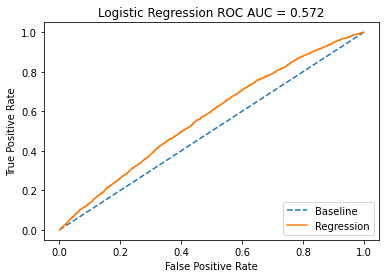

accuracy_score: 0.912
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0
log_loss: 3.055
roc_auc_score: 0.572
average_precision_score: 0.088
brier_score_loss: 0.088


In [17]:
# построим метрики
scores_function(Y_val, Y_predicted, probs)

Метрики модели практически нулевые

## Рассмотрим данные подробнее и выполним предобработку:

## client-id

In [18]:
data.client_id.describe()

count    110148.000000
mean      55074.500000
std       31797.133063
min           1.000000
25%       27537.750000
50%       55074.500000
75%       82611.250000
max      110148.000000
Name: client_id, dtype: float64

In [19]:
data.client_id.nunique()

110148

*Все значения в данной колонке уникальны, по сути это порядковый номер клиента в таблице, к примеру, используемый для последующего соединения таблиц, если вдруг, база данных будет пополняться и нам потребуется исключить дубликаты хотябы по этому порядковому номеру.*  
***Полагаю, что в дальнейшем, для построения модели она (колонка) нам не нужна. Но удалять мы ее не будем, пока.***

## app_date

In [20]:
data.app_date.value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

Данную колонку мы уже ранее отмечали, как *временной ряд*    
Уникальных дат обращений клиентов **120**  
Необходимо перевести ее в соответсвующий формат и поглядеть, какие годы и месяцы в ней представлены.

In [21]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [22]:
data.app_date.describe()

count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

In [23]:
print(f"{data['app_date'].dt.year.unique()}\n{data['app_date'].dt.month_name().unique()}\
    \n{sorted(data['app_date'].dt.day.unique())}")

[2014]
['February' 'March' 'January' 'April']    
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Отсюда видно, что в данных представлен у нас всего лишь один год - 2014, месяцы тоже не все, с января по апрель (включительно)

**Посмотрим на дни недели обращений клиентов в банк:**

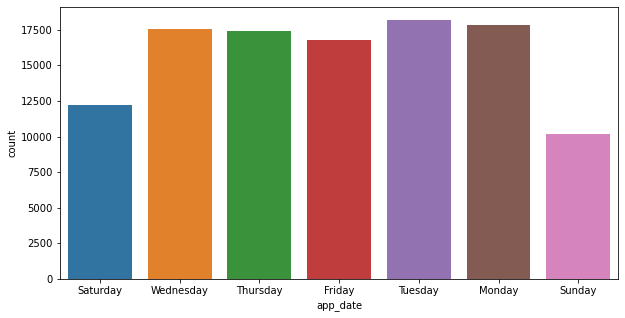

In [24]:
fig = plt.subplots(figsize=(10, 5))
sns.countplot(x=data['app_date'].dt.day_name());

Распределение по дням недели плюс-пинус нормальное, по будням достаточно равномерное, и гораздо меньше в выходные    
Информация по дням недели и по месяцам более содержательная, нежели сами числа и год  
Выделим ее отдельно, а от самой колонки впоследствии можно избавиться.

In [25]:
data['month'] = data.app_date.apply(lambda s: s.month)
data['day_of_week'] = data.app_date.apply(lambda x: dt.weekday(x))

# создадим признак: давности заявки (относительно сегодняшнего дня)
data['app_time']= data['app_date'].apply(lambda x: (dt.today()-x).days)
# удаляем ненужный столбец
data.drop('app_date', axis=1, inplace=True)

-0.02916903568437892

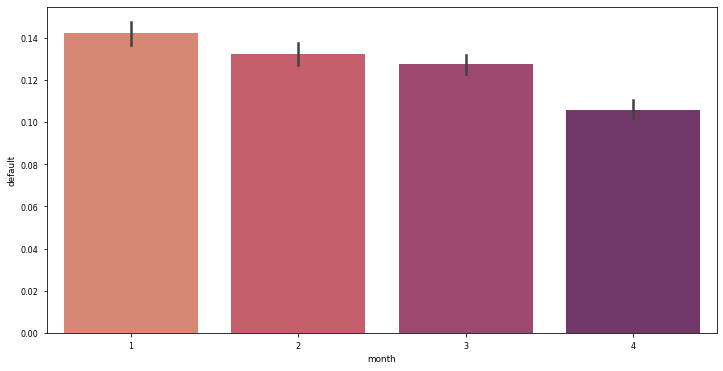

In [26]:
display(data.loc[:,'default'].astype('float64').corr(data.loc[:,'month']).astype('float64'))
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 6))
color_text = plt.get_cmap('flare')(0.85)
sns.barplot(data=data[data['sample']==1], x=data.loc[data['sample']==1,'month'], y='default', palette="flare");

Корреляция у признака отрицательная

## BIN COLS: sex, car, car_type, good_work, foreign_passport

## sex

F    61836
M    48312
Name: sex, dtype: int64

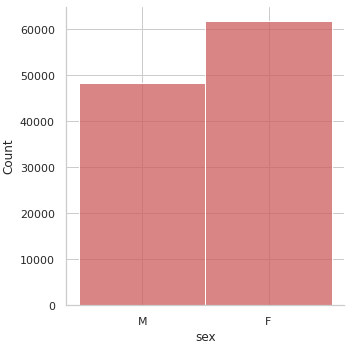

In [27]:
display(data.sex.value_counts())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['sex'], bins=50, color='#CD5C5C')

**Женщины** чаще обращаются в банк для подачи заявки

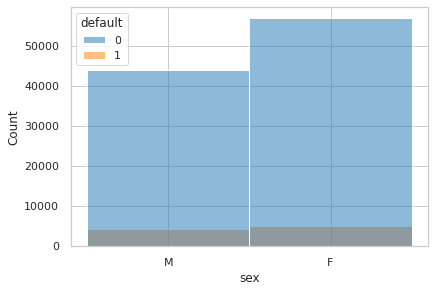

In [28]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.histplot(data=data, x="sex", hue="default")

Среди **женщин** также, и девфолтов немнго больше, чем среди мужчин

## car

In [29]:
data.car.value_counts()

N    74290
Y    35858
Name: car, dtype: int64

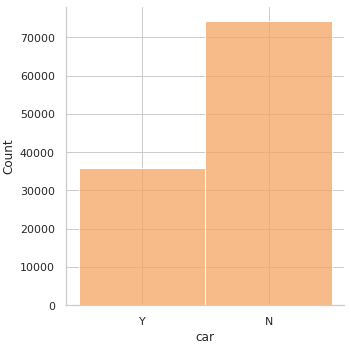

In [30]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['car'], bins=50, color='#F4A460')

В большинстве своем, автомобиля у заемщиков нет  

**Посмотрим распределение этого признака по дефолтным клиентам:**

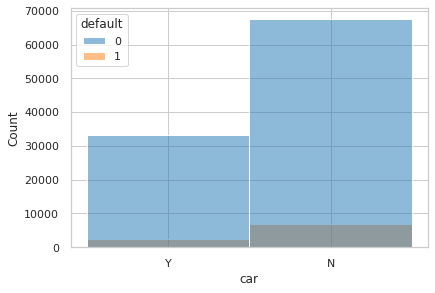

In [31]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.histplot(data=data, x="car", hue="default")

## car_type

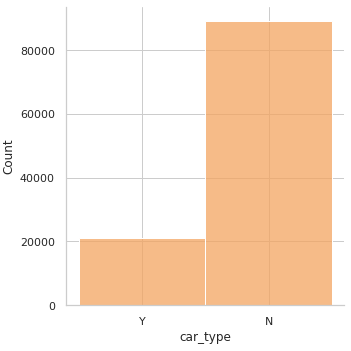

In [32]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['car_type'], bins=50, color='#F4A460')

Чаще всего встречается у клиентов автомобиль отечественного производителя

## good_work

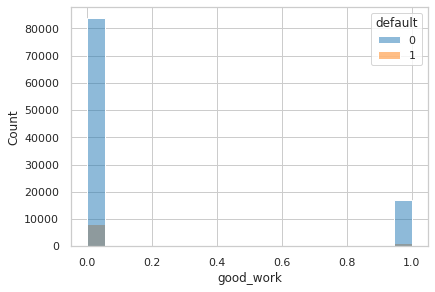

In [33]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.histplot(data=data, x="good_work", hue="default")

Начиличе хорошей работы помогает клиентам избежать дефолта

## foreign_passport

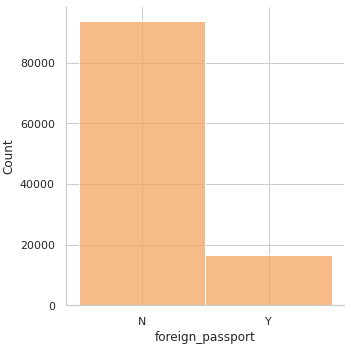

In [34]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['foreign_passport'], bins=50, color='#F4A460')

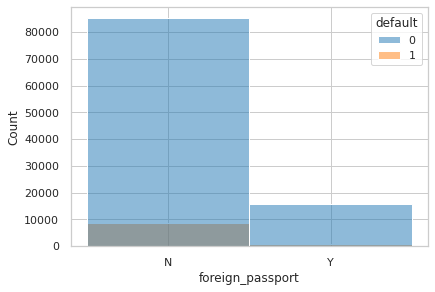

In [35]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.histplot(data=data, x="foreign_passport", hue="default")

Люди, имеющие загранпаспорт вразы реже совершают дефолт, чем те, у кого его нет.
При этом, среди заемщиков преобладают люди без загранпаспорта.

***Таким образом, для дальнейшей работы необходимо эти бинарные переменные сделать таковыми: перекодировать на 1 и 0
А поможет нам в этом LabelEncoder:***

In [36]:
lb = LabelEncoder()

for column in bin_cols:
    data[column] = lb.fit_transform(data[column])
    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,month,day_of_week,app_time
0,25905,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,1,2,5,2837
1,63161,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,1,3,2,2798
2,25887,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,1,2,5,2837
3,16222,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1,1,3,2846
4,101655,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,1,4,4,2761


*Мужской пол - 1, Женский - 0, Y - 1, N - 0 соответственно*

## NUM_COLS: age, decline_app_cnt, income, bki_request_cnt, score_bki, region_rating, first_time


## age

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='count'>

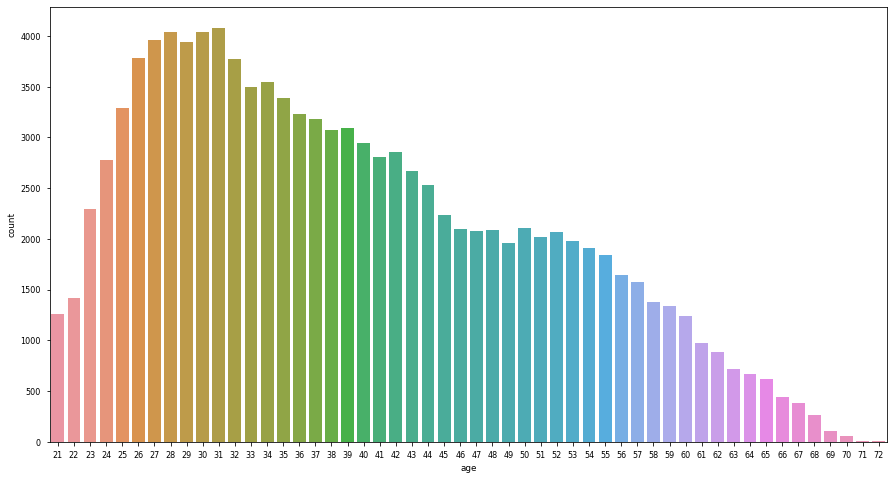

In [37]:
display(data.age.describe())
fig = plt.subplots(figsize=(15, 8))
sns.countplot(x=data['age'])

In [38]:
IQR(data, 'age')

Нижняя граница выбросов: 3.0 
Верхняя граница выбросов: 75.0
Количество выбросов: 0


Выбросов нет, но признок распределен не равномерно (хвост справа)  
Попробуем его логарифмировать и посмотреть на данные:

In [39]:
log_func(data, 'age')

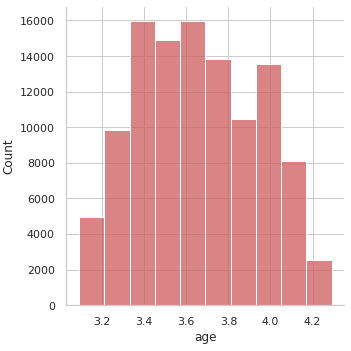

In [40]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['age'],bins=10, color='#CD5C5C')

## decline_app_cnt

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

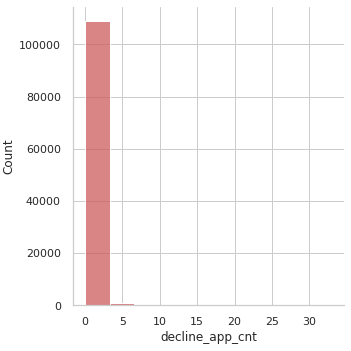

In [41]:
display(data.decline_app_cnt.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['decline_app_cnt'],bins=10, color='#CD5C5C')

In [42]:
data.groupby(by = 'default')['decline_app_cnt'].mean()

default
0    0.250675
1    0.515472
Name: decline_app_cnt, dtype: float64

Видно, что в среднем, у людей, которые не отдали кредит - больше отклоненных заявок   
**Посмотрим наличие выбросов:**

Нижняя граница выбросов: 0.0 
Верхняя граница выбросов: 0.0
Количество выбросов: 18677


<AxesSubplot:>

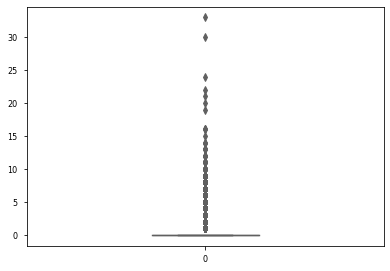

In [43]:
IQR(data, 'decline_app_cnt')
sns.boxplot(data=data['decline_app_cnt'], palette="Blues", width=0.3)

In [44]:
data.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

*В данном случае, такая оценка выбросов (квартили) нам не подходит, можно, попробовать логарифмировать, конечно, но думаю, что здесь будет разумным этот признак видоизменить и отнести его к бинарному - были отказы - 1, не было отказов - 0, таким образом, получится более информативно*


In [45]:
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: 1 if x>1 else x)

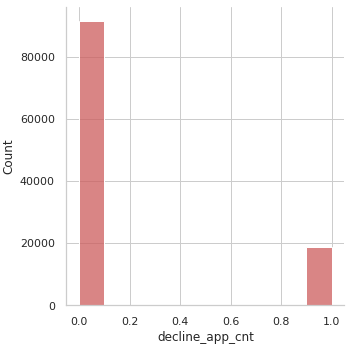

In [46]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['decline_app_cnt'],bins=10, color='#CD5C5C')

## income

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

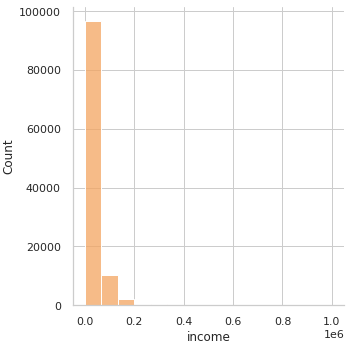

In [47]:
display(data.income.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['income'],bins = 15, color='#F4A460')

In [48]:
# проверим наличие выбросов
IQR(data, 'income')

Нижняя граница выбросов: -22000.0 
Верхняя граница выбросов: 90000.0
Количество выбросов: 7000


In [49]:
fill_mean(data, 'income')

**Теперь стандартизируем данные с помощью *MinMaxScaler* и еще раз посмотрим на распределение признака:**

In [50]:
sclr = MinMaxScaler()
income_minmax = sclr.fit_transform(data.loc[:,['income']])
data['income'] = income_minmax

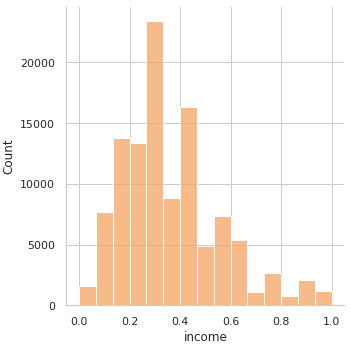

In [51]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['income'],bins = 15, color='#F4A460')

## bki_request_cnt

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

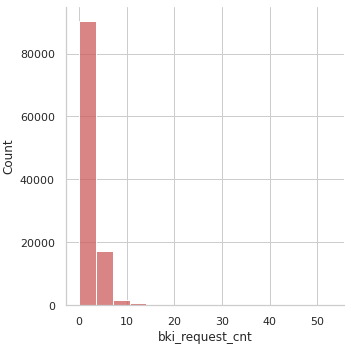

In [52]:
display(data.bki_request_cnt.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['bki_request_cnt'],bins = 15, color='#CD5C5C')

Имеется хвост справа, необходимо проверить на выбросы:

In [53]:
IQR(data, 'bki_request_cnt')

Нижняя граница выбросов: -4.5 
Верхняя граница выбросов: 7.5
Количество выбросов: 2636


In [54]:
# заменим выбросы на среднее значение
fill_mean(data, 'bki_request_cnt')

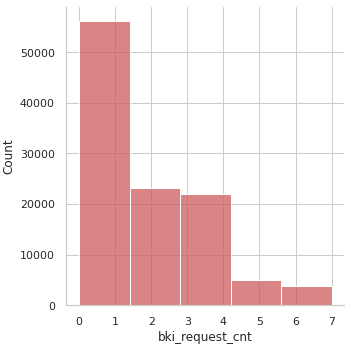

In [55]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['bki_request_cnt'],bins = 5, color='#CD5C5C')

## score_bki

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

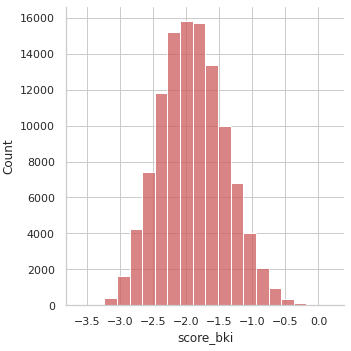

In [56]:
display(data.score_bki.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['score_bki'],bins = 20, color='#CD5C5C')

Нижняя граница выбросов: -3.299251946250001 
Верхняя граница выбросов: -0.5290698762499992
Количество выбросов: 518


<AxesSubplot:>

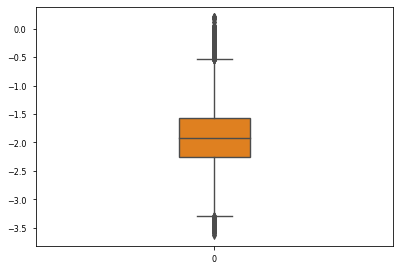

In [57]:
IQR(data, 'score_bki')
sns.boxplot(data=data['score_bki'], palette="autumn", width=0.2)

Cкоринговый балл по данным из БКИ, распределение нормальное, выбросов не много, можем заменить на среднее значение

In [58]:
fill_mean(data, 'score_bki')

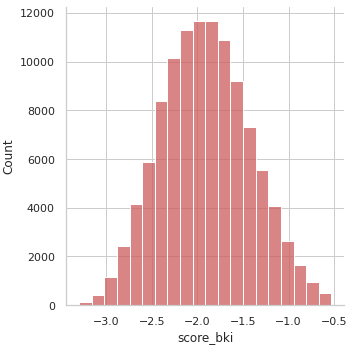

In [59]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['score_bki'],bins = 20, color='#CD5C5C')

In [60]:
# посмотрим на кореляцию
round(data.loc[:,'default'].astype('float64').corr(
     data.loc[:,'score_bki']).astype('float64'), 3)

0.135

## region_rating

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

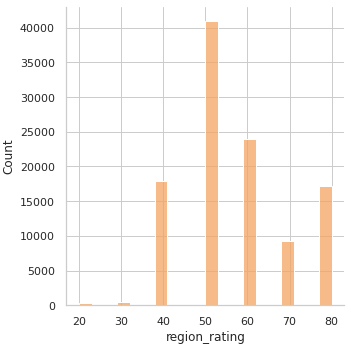

In [61]:
display(data.region_rating.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['region_rating'],bins = 20, color='#F4A460')

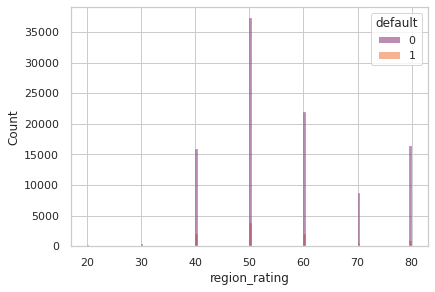

In [62]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"), sns.color_palette('inferno', n_colors=2):
    sns.histplot(data=data, x="region_rating", hue="default")

## first_time

count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64

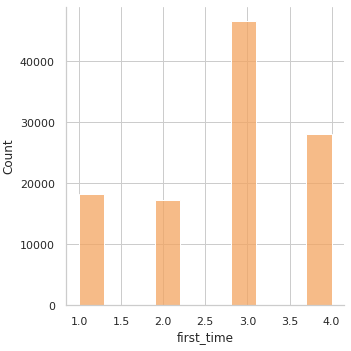

In [63]:
display(data.first_time.describe())
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['first_time'],bins = 10, color='#F4A460')

## CAT_COLS - education, home_address, work_address, sna

## education

count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Пропущенных значенией: 478


<AxesSubplot:>

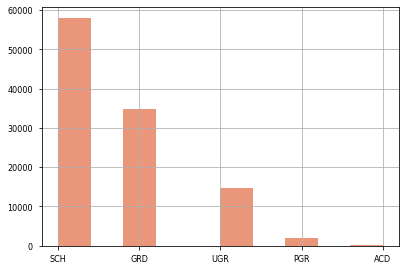

In [64]:
display(data.education.describe(), data.education.value_counts())
print('Пропущенных значенией:', data.education.isnull().sum())
data.education.hist(color='#E9967A')

Для справки:
- SCH (1) - school - те, у кого среднее образование (только школа)
- UGR (2) - undergraduate - бакалавры
- GRD (3) - магистры
- PGR (4) - postgraduate - учёная степень PhD 
- ACD (5) - высший уровень

Эта колонка с пропусками, имеем часто встречающееся значение SCH, можем использовать его для замены пропусков:

In [65]:
data['education'] = data['education'].fillna('SCH')

In [66]:
display(data.education.value_counts())
print('Пропущенных значенией:', data.education.isnull().sum())

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Пропущенных значенией: 0


In [67]:
# Cоздадим словарь для замены
edu_dict = {'SCH': 1,
            'UGR': 2,
            'GRD': 3,
            'PGR': 4,
            'ACD': 5
            }
data['education'] = data['education'].replace(to_replace=edu_dict)
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,month,day_of_week,app_time
0,25905,1,1,4.143135,1,1,0,0,-2.008753,1.0,50,1,2,0.191011,4,1,0,0,1,2,5,2837
1,63161,1,0,4.094345,0,0,0,0,-1.532276,3.0,50,2,3,0.202247,4,1,0,0,1,3,2,2798
2,25887,1,1,3.258097,1,0,1,0,-1.408142,1.0,80,1,2,0.325843,1,4,1,0,1,2,5,2837
3,16222,1,0,3.988984,0,0,0,0,-2.057471,2.0,50,2,3,0.101124,1,3,0,0,1,1,3,2846
4,101655,3,1,3.891820,0,0,0,1,-1.244723,1.0,60,2,3,0.325843,1,4,1,0,1,4,4,2761


## home_address

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

<AxesSubplot:>

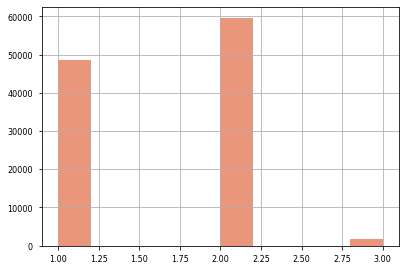

In [68]:
display(data.home_address.value_counts())
data.home_address.hist(color='#E9967A')

*Признак, обозначающий домашний адрес, данные разбиты на 3 группы, в логарифмировании нет необходимости, пропусков нет*

##  work_address

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

<AxesSubplot:>

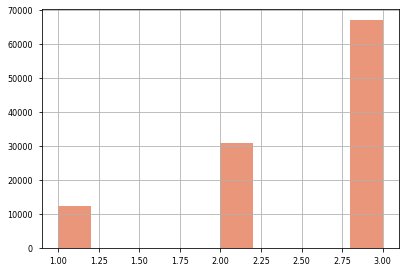

In [69]:
display(data.work_address.value_counts())
data.work_address.hist(color='#E9967A')

*Такая же картина по "смыслу" как и у домашнего адреса*

## sna

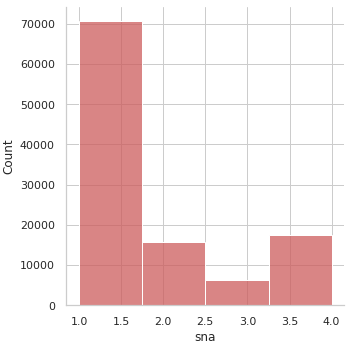

In [70]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.displot(data['sna'],bins = 4, color='#CD5C5C')

У признака 4 уникальных значения, показывает связь заёмщика с клиентами банка

## default

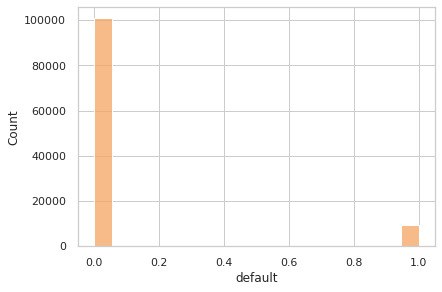

In [71]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    sns.histplot(data=data, x="default", color='#F4A460')

Дефолтных клиентов меньше намного, класс не сбалансирован

## Корреляционный анализ для числовых пременных (num_cols):

<AxesSubplot:>

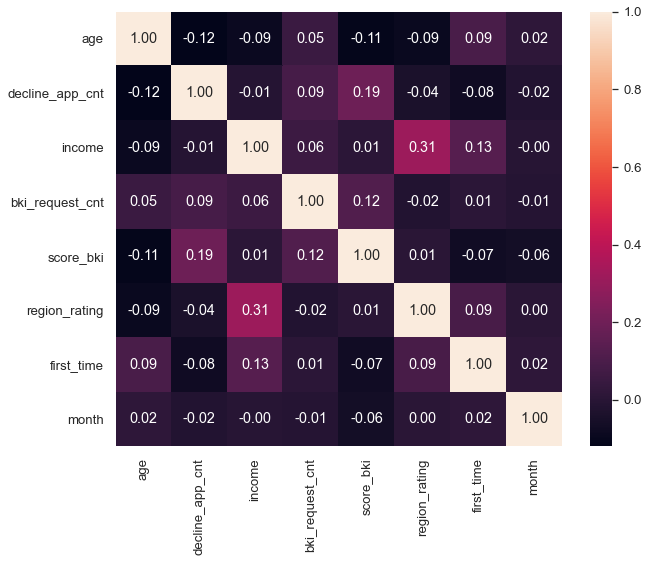

In [72]:
sns.set(font_scale=1.2)
plt.subplots(figsize=(10,8))
sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f')

Особенно коррелируют признаки: *region_rating* и *income* - **0.31**, а также *score_bki* и *decline_app_cnt* - **0.19**

### Значимость числовых переменных по ANOVA F test:


<AxesSubplot:title={'center':'Значимость бин. и категор. переменных (ANOVA)'}>

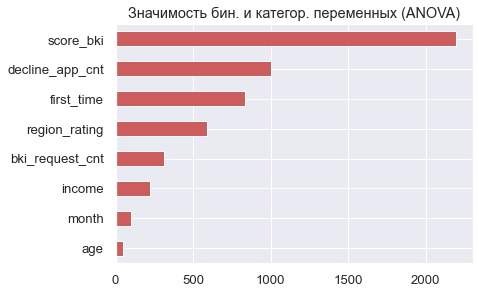

In [73]:
temp_df = data[data['sample']==1]

imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh',title = 'Значимость бин. и категор. переменных (ANOVA)', color='#CD5C5C')

**На основании данного теста самый значимый показатель - это score_bki (скоринговый балл по данным из БКИ), следом за ним уже кол-во отказов**

## Значимость категориальных и бинарных признаков (cat_cols + bin_cols):

<AxesSubplot:title={'center':'Значимость бин. и категор. переменных Mutual Classif.'}>

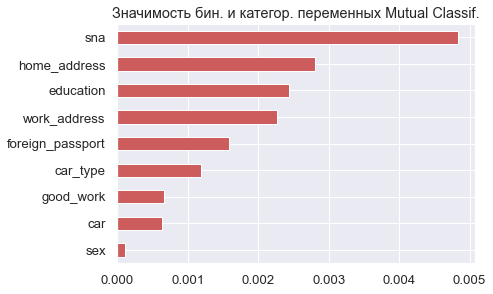

In [74]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols],
                                     data['default'], discrete_features =True),
                                     index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',title = 'Значимость бин. и категор. переменных Mutual Classif.', color='#CD5C5C')

Здесь прослеживается важность связи клиентов с сотрудниками **sna**

In [75]:
data.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,month,day_of_week,app_time
0,25905,1,1,4.143135,1,1,0,0,-2.008753,1.0,50,1,2,0.191011,4,1,0,0,1,2,5,2837
1,63161,1,0,4.094345,0,0,0,0,-1.532276,3.0,50,2,3,0.202247,4,1,0,0,1,3,2,2798
2,25887,1,1,3.258097,1,0,1,0,-1.408142,1.0,80,1,2,0.325843,1,4,1,0,1,2,5,2837


## 2. Пробуем строить модель:

In [76]:
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values # целевая переменная

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_SEED)

In [78]:
#Обучаем модель, генерируем результат и сравниваем с тестом
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

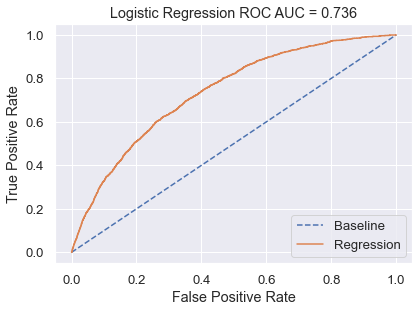

accuracy_score: 0.875
precision_score: 0.388
recall_score: 0.017
f1_score: 0.033
log_loss: 4.317
roc_auc_score: 0.736
average_precision_score: 0.128
brier_score_loss: 0.125
Confusion matrix
[[12884    49]
 [ 1796    31]]


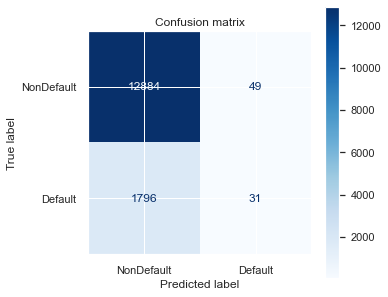

In [79]:
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model, X_test, y_test)

**Таким образом, на данный момент имеем:**
Модель на данный момент плоха, несмотря на высокую ROC-AUC,
По матрице ошибок видно, что дефолтных клиентов мы идентифицировали плохо: 29 из 1798 чел, и метрика recall низкая (0,016), соответственно.  
Таким образом, мы выдвдим кредиты тем, кто их не отдаст.   
Работаем дальше!

Посмотрим корреляцию на всех данных, возможно, понадобиться некоторая доработка в feature engineering 

### Матрица корреляций всех данных:  

<AxesSubplot:>

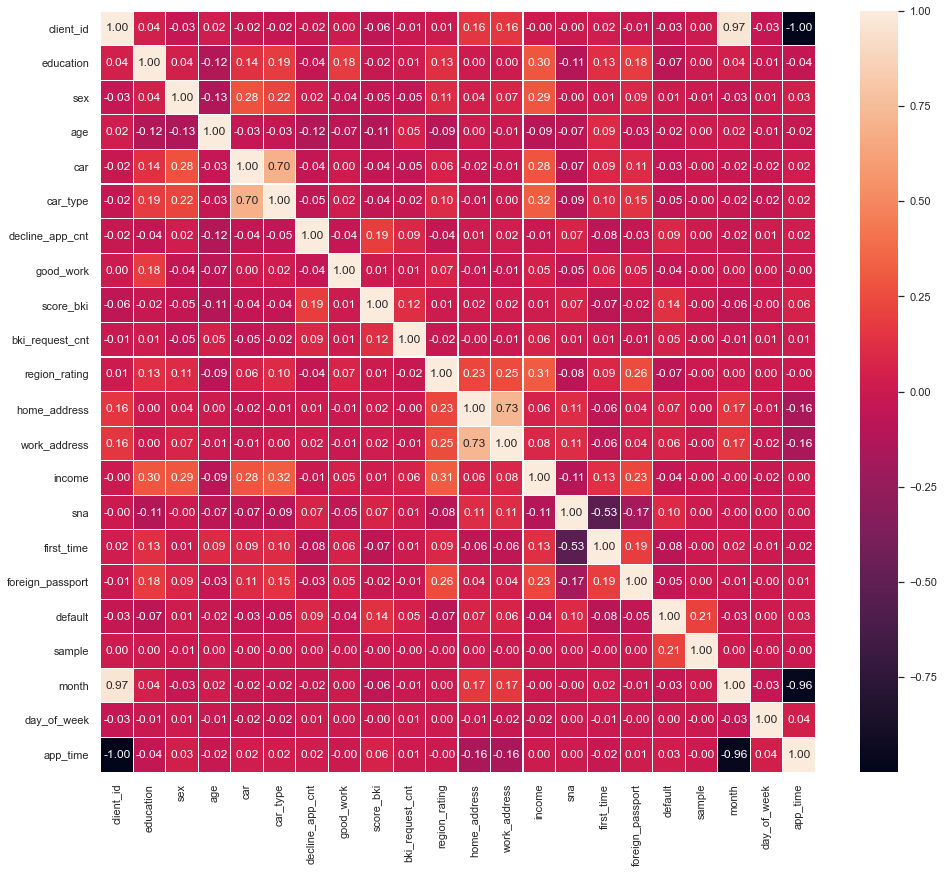

In [80]:
sns.set(font_scale=1)
plt.subplots(figsize=(16,14))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths = 0.1)

Отсюда видно, что коррелируют адрес домашний и адрес рабочий (home_address - work_address), можно над этим поработать, потом наличие и тип автомобиля (car-car_type), также сильная корреляция у first_time и sna  

**Попробуем:**
- обьединить car и car_type
- удалить work_address и first_time, поскольку их корреляция с default наименьшая
- логарифмировать  некоторые числовые признаки (если не будет видимых улучшений)
- попробовать ***гиперпараметры*** 

In [81]:
data['car'] = data['car'] + data['car_type']
data.drop(['car_type', 'work_address', 'first_time', 'app_time'], inplace=True, axis=1)

In [82]:
data.head(10)

,client_id,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,foreign_passport,default,sample,month,day_of_week
0,25905,1,1,4.143135,2,0,0,-2.008753,1.0,50,1,0.191011,4,0,0,1,2,5
1,63161,1,0,4.094345,0,0,0,-1.532276,3.0,50,2,0.202247,4,0,0,1,3,2
2,25887,1,1,3.258097,1,1,0,-1.408142,1.0,80,1,0.325843,1,1,0,1,2,5
3,16222,1,0,3.988984,0,0,0,-2.057471,2.0,50,2,0.101124,1,0,0,1,1,3
4,101655,3,1,3.891820,0,0,1,-1.244723,1.0,60,2,0.325843,1,1,0,1,4,4
5,41415,1,1,3.332205,1,0,1,-2.032257,0.0,50,1,0.157303,2,0,0,1,2,1
6,28436,1,1,3.688879,0,0,0,-2.225004,0.0,60,1,0.303371,1,0,0,1,2,1
7,68769,1,0,3.688879,0,0,0,-1.522739,1.0,50,2,0.494382,3,0,0,1,3,0
8,38424,1,0,3.931826,1,1,0,-1.676061,0.0,50,1,0.325843,1,0,0,1,2,4
9,4496,2,0,4.007333,0,0,0,-2.695176,1.0,50,2,0.258427,1,0,0,1,1,4


<AxesSubplot:>

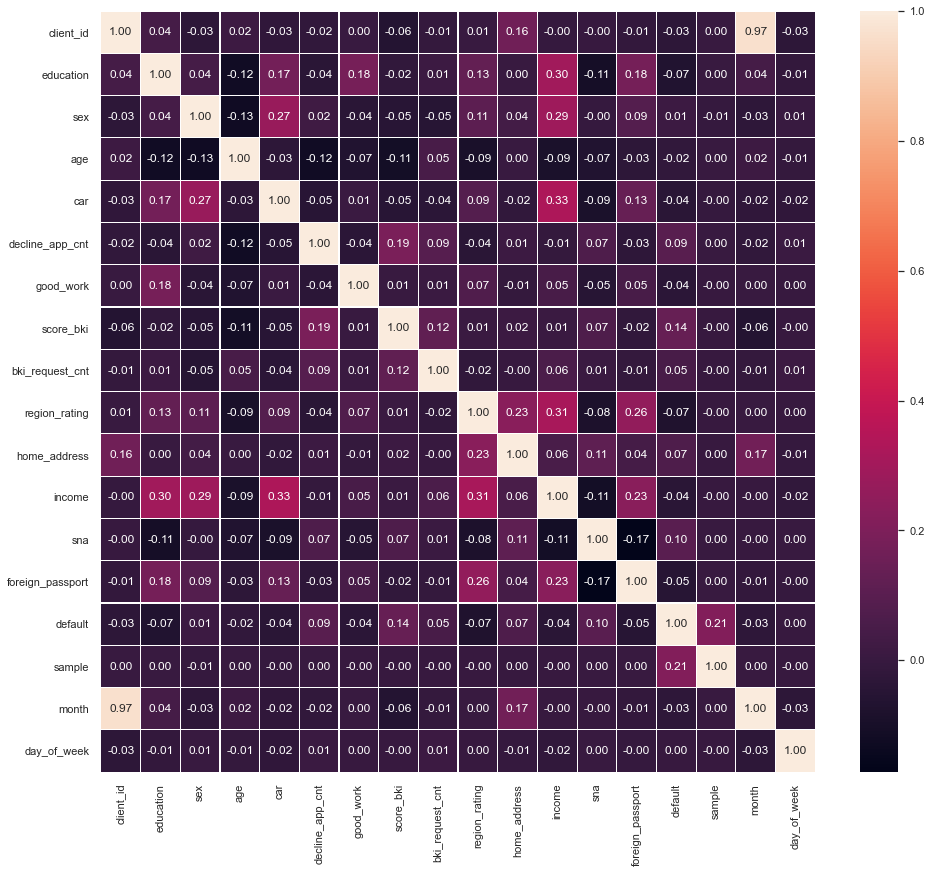

In [83]:
sns.set(font_scale=1)
plt.subplots(figsize=(16,14))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths = 0.1)

## 2.1 Пробуем строить модель (пока без гиперпараметров):

In [84]:
train_data2 = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data2 = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data2.drop(['default'], axis=1)
y = train_data2['default'].values  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [85]:
#Обучаем модель, генерируем результат и сравниваем с тестом
model2 = LogisticRegression(solver='liblinear')
model2.fit(X_train, y_train)

y_pred_prob = model2.predict_proba(X_test)[:,1]
y_pred = model2.predict(X_test)

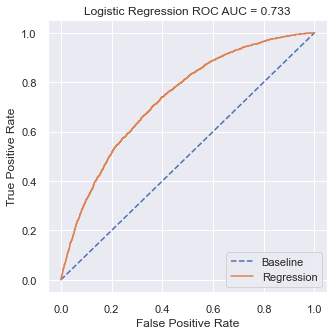

accuracy_score: 0.875
precision_score: 0.408
recall_score: 0.017
f1_score: 0.033
log_loss: 4.308
roc_auc_score: 0.733
average_precision_score: 0.129
brier_score_loss: 0.125
Confusion matrix
[[12888    45]
 [ 1796    31]]


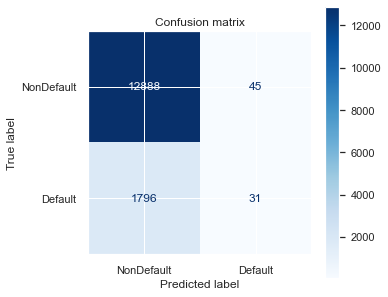

In [86]:
# метрики оценки
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model2, X_test, y_test)

***Улучшения микроскопические, нормализуем пожалуй, то, что осталось и пробуем гиперпараметры!***

In [87]:
data.head(3)

,client_id,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,foreign_passport,default,sample,month,day_of_week
0,25905,1,1,4.143135,2,0,0,-2.008753,1.0,50,1,0.191011,4,0,0,1,2,5
1,63161,1,0,4.094345,0,0,0,-1.532276,3.0,50,2,0.202247,4,0,0,1,3,2
2,25887,1,1,3.258097,1,1,0,-1.408142,1.0,80,1,0.325843,1,1,0,1,2,5


In [88]:
#нормализуем признак score_bki
score_minmax = sclr.fit_transform(data.loc[:,['score_bki']])
data['score_bki'] = score_minmax

In [89]:
data.head(3)

,client_id,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,foreign_passport,default,sample,month,day_of_week
0,25905,1,1,4.143135,2,0,0,0.466012,1.0,50,1,0.191011,4,0,0,1,2,5
1,63161,1,0,4.094345,0,0,0,0.638113,3.0,50,2,0.202247,4,0,0,1,3,2
2,25887,1,1,3.258097,1,1,0,0.682949,1.0,80,1,0.325843,1,1,0,1,2,5


### 2.2 Убираем несколько колонок, которые показали низкую значимость на тестах: 'sex', 'month', 'age'

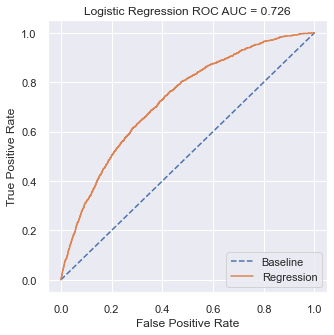

accuracy_score: 0.875
precision_score: 0.403
recall_score: 0.014
f1_score: 0.026
log_loss: 4.303
roc_auc_score: 0.726
average_precision_score: 0.128
brier_score_loss: 0.125
Confusion matrix
[[12896    37]
 [ 1802    25]]


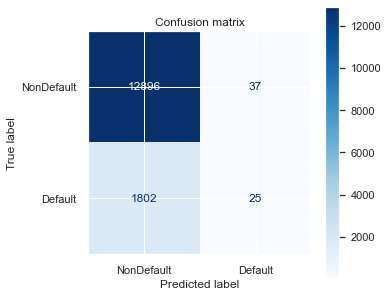

In [90]:
'''Попробуем без колонок 'sex', 'month', 'age', 
поскольку на тестах значимости они были на последнем месте'''

train_data2 = data.query('sample == 1').drop(['sample', 'client_id', 'age','sex', 'month'], axis=1)
test_data2 = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data2.drop(['default'], axis=1)
y = train_data2['default'].values  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

#Обучаем модель, генерируем результат и сравниваем с тестом
model2 = LogisticRegression(solver='liblinear')
model2.fit(X_train, y_train)

y_pred_prob = model2.predict_proba(X_test)[:,1]
y_pred = model2.predict(X_test)

# метрики оценки
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model2, X_test, y_test)

## 3. Пробуем строить модель c гиперпараметрами:

### 3.1 Пробуем гиперпараметры: коэфф. регуляризации, балансировку выборки, (колонки 'sex', 'month', 'age' оставляем)

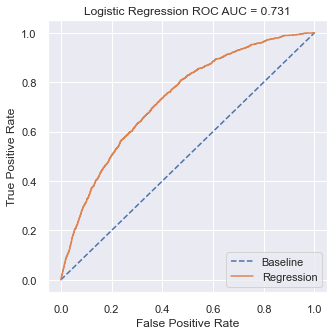

accuracy_score: 0.663
precision_score: 0.219
recall_score: 0.669
f1_score: 0.33
log_loss: 11.628
roc_auc_score: 0.731
average_precision_score: 0.187
brier_score_loss: 0.337
Confusion matrix
[[8569 4364]
 [ 605 1222]]


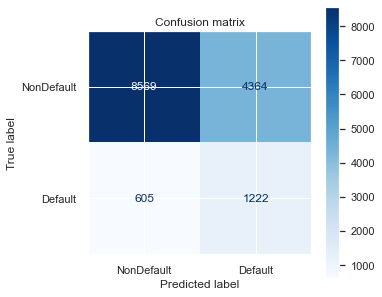

In [91]:
'''Попробуем с гиперпараметрами, не убирая вышеуказанных колонок,
C - коэффициент регуляризации, и балансировка выборки'''

train_data = data.query('sample == 1').drop(
    ['sample', 'client_id', 'month'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

# Обучаем модель, генерируем результат и сравниваем с тестом
model = LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# метрики оценки
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model, X_test, y_test)

### 3.2 Пробуем гиперпараметры: коэфф. регуляризации, балансировку выборки, (колонки 'sex', 'month', 'age' убираем)

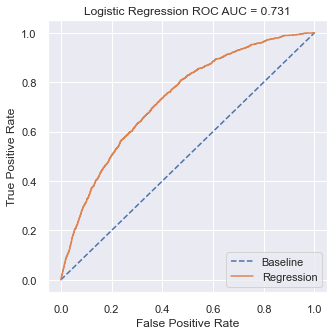

accuracy_score: 0.663
precision_score: 0.219
recall_score: 0.669
f1_score: 0.33
log_loss: 11.628
roc_auc_score: 0.731
average_precision_score: 0.187
brier_score_loss: 0.337
Confusion matrix
[[8569 4364]
 [ 605 1222]]


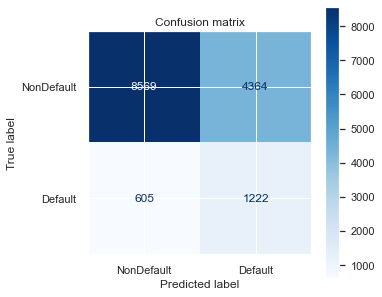

In [92]:
'''Попробуем с гиперпараметрами, без колонок 'sex', 'month', 'age', 
поскольку на тестах значимости они были на последнем месте,
C - коэффициент регуляризации, и балансировка выборки'''

train_data2 = data.query('sample == 1').drop(['sample', 'client_id', 'age','sex', 'month'], axis=1)
test_data2 = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

# Обучаем модель, генерируем результат и сравниваем с тестом
model = LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# метрики оценки
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model, X_test, y_test)

Что с колонками: 'sex', 'month', 'age', что без них, на результат модели, после регуляризации и балансировки, это не влияет

### 3.3 Пробуем гиперпараметры: коэфф. регуляризации, добавляем штраф, балансировку выборки, (колонки 'sex', 'month', 'age' оставляем)

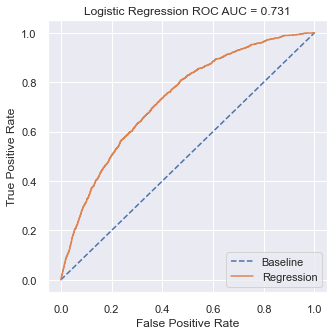

accuracy_score: 0.663
precision_score: 0.219
recall_score: 0.669
f1_score: 0.33
log_loss: 11.628
roc_auc_score: 0.731
average_precision_score: 0.187
brier_score_loss: 0.337
Confusion matrix
[[8569 4364]
 [ 605 1222]]


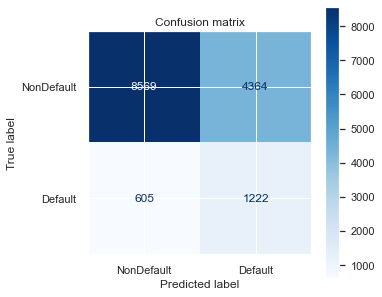

In [93]:
'''Попробуем с гиперпараметрами, не убирая вышеуказанных колонок,
C - коэффициент регуляризации, и балансировка выборки,
Добавлен параметр штрафа-модели penalty = l2'''

train_data = data.query('sample == 1').drop(
    ['sample', 'client_id', 'month'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_data.drop(['default'], axis=1)
y = train_data['default'].values  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

# Обучаем модель, генерируем результат и сравниваем с тестом
model = LogisticRegression(C=1, class_weight='balanced',penalty = 'l2', dual = False, solver='liblinear')
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# метрики оценки
scores_function(y_test, y_pred, y_pred_prob)
confusion_matrix(model, X_test, y_test)

**На данный момент версия  модели 3.3 является лучшей, с учетом использования регуляризации, балансировки выборки и штрафа модель гораздо лучше предсказывает несбалансированные данные.**

## Submission

In [174]:
data.head()

,client_id,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,foreign_passport,default,sample,month,day_of_week
0,25905,1,1,4.143135,2,0,0,0.466012,1.0,50,1,0.191011,4,0,0,1,2,5
1,63161,1,0,4.094345,0,0,0,0.638113,3.0,50,2,0.202247,4,0,0,1,3,2
2,25887,1,1,3.258097,1,1,0,0.682949,1.0,80,1,0.325843,1,1,0,1,2,5
3,16222,1,0,3.988984,0,0,0,0.448416,2.0,50,2,0.101124,1,0,0,1,1,3
4,101655,3,1,3.891820,0,0,1,0.741976,1.0,60,2,0.325843,1,1,0,1,4,4


---------------------------------

In [94]:
# Делим train на тренировочную и тестовую выборки 
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

X_train = train_data.drop(['default', 'client_id'], axis=1)
Y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [95]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 17), (73799, 17), (73799, 15), (59039,), (36349, 16))

In [96]:
# Обучаем модель:
model = LogisticRegression(C = 1, class_weight='balanced',penalty = 'l2', dual = False, solver='liblinear')
model.fit(X_train, Y_train)

X_test = test_data.drop(['default', 'client_id'], axis=1)
y_pred_final = model.predict_proba(X_test)[:, 1]

submission = pd.concat([test.client_id, pd.Series(y_pred_final,name='default')],axis=1)
display(submission)
submission.to_csv('submission.csv', index=False)

,client_id,default
0,74835,0.241889
1,17527,0.769154
2,75683,0.304297
3,26883,0.395331
4,28862,0.147961
...,...,...
36344,83775,0.805190
36345,106254,0.125347
36346,81852,0.780100
36347,1971,0.627836


-------------------------